<center>
    <h1>Converting the images to 256 x 256</h1>
<center>

<center>
<img src="https://hubmapconsortium.org/wp-content/uploads/2019/01/HuBMAP-Retina-Logo-Color.png">
</center>

## Converting the images to 256 x 256

This notebook converts the images to 256x256 image dataset for the initial fast prototyping. Based on the size of the detected features, you can chose which dataset size you want to train with. 

I've made serveral options so you can experiment with them on your own:

**Precomputed Datasets**

#### [Dataset (512 x 512)](https://www.kaggle.com/datasets/thedevastator/hubmap-2022-512x512/)

#### [Dataset (256 x 256)](https://www.kaggle.com/datasets/thedevastator/hubmap-2022-256x256/)

#### [Dataset (128 x 128)](https://www.kaggle.com/datasets/thedevastator/hubmap-2022-128x128/settings)

_____

### Description 

This notebook is part of a series providing a fast.ai starter pytorch pipeline based on a U-shape network (UneXt50) that was used on multiple competitions in the past and includes several tricks from the previous segmentation competitions.
It is [dividing the images into tiles](https://www.kaggle.com/code/thedevastator/converting-to-256x256), selection of tiles with tissue, evaluation of the predictions of multiple models with TTA, combining the tile masks back into image level masks, and conversion into RLE. The [inference](https://www.kaggle.com/code/thedevastator/inference-fastai-baseline) is performed based on models trained in the [fast.ai training notebook](https://www.kaggle.com/code/thedevastator/training-fastai-baseline).

**Training & Dataset Creation**

- #### Training Notebook [here](https://www.kaggle.com/code/thedevastator/training-fastai-baseline). 
- #### Inference Notebook [here](https://www.kaggle.com/code/thedevastator/inference-fastai-baseline). 



> **Credit**
> #### Based on the excellent [notebook](https://www.kaggle.com/iafoss/256x256-images) by [iafoss](https://www.kaggle.com/iafoss) 
> All credit to belongs to the original author!

#데이터 불러오기

In [2]:
!gdown 1VnXyPKFiRL5Cvmw3UXLIK6Id93vjgKW5

Downloading...
From: https://drive.google.com/uc?id=1VnXyPKFiRL5Cvmw3UXLIK6Id93vjgKW5
To: /content/hubmap-organ-segmentation.zip
100% 6.20G/6.20G [01:05<00:00, 94.8MB/s]


In [9]:
%cd /content/sample_data

/content/sample_data


In [10]:
!unzip /content/hubmap-organ-segmentation.zip

Archive:  /content/hubmap-organ-segmentation.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_images/10078.tiff  
  inflating: train.csv               
  inflating: train_annotations/10044.json  
  inflating: train_annotations/10274.json  
  inflating: train_annotations/10392.json  
  inflating: train_annotations/10488.json  
  inflating: train_annotations/10610.json  
  inflating: train_annotations/10611.json  
  inflating: train_annotations/10651.json  
  inflating: train_annotations/10666.json  
  inflating: train_annotations/10703.json  
  inflating: train_annotations/10892.json  
  inflating: train_annotations/10912.json  
  inflating: train_annotations/10971.json  
  inflating: train_annotations/10992.json  
  inflating: train_annotations/11064.json  
  inflating: train_annotations/1123.json  
  inflating: train_annotations/11448.json  
  inflating: train_annotations/11497.json  
  inflating: train_annotations/1157.json  
  inflati

In [3]:
!!gdown 1FunmTUoB6leSID1Fn24ztChzLYCP4EtA
!gdown 1FQTXgoRs76wFFhsMQkrdgvt3sknyaTKd

Downloading...
From: https://drive.google.com/uc?id=1FQTXgoRs76wFFhsMQkrdgvt3sknyaTKd
To: /content/masks.zip
100% 3.77M/3.77M [00:00<00:00, 184MB/s]


In [4]:
!mkdir /content/sample_data/output_mask
!mkdir /content/sample_data/output_train

In [5]:
%cd /content/sample_data/output_train

/content/sample_data/output_train


In [ ]:
!unzip /content/train.zip

In [7]:
%cd /content/sample_data/output_mask

/content/sample_data/output_mask


In [8]:
!unzip /content/masks.zip

Archive:  /content/masks.zip
  inflating: 10044_0000.png          
  inflating: 10044_0001.png          
  inflating: 10044_0002.png          
  inflating: 10044_0003.png          
  inflating: 10044_0004.png          
  inflating: 10044_0005.png          
  inflating: 10044_0007.png          
  inflating: 10044_0008.png          
  inflating: 10274_0000.png          
  inflating: 10274_0001.png          
  inflating: 10274_0002.png          
  inflating: 10274_0003.png          
  inflating: 10274_0004.png          
  inflating: 10274_0005.png          
  inflating: 10274_0006.png          
  inflating: 10274_0007.png          
  inflating: 10274_0008.png          
  inflating: 10392_0000.png          
  inflating: 10392_0001.png          
  inflating: 10392_0002.png          
  inflating: 10392_0003.png          
  inflating: 10392_0004.png          
  inflating: 10392_0005.png          
  inflating: 10392_0006.png          
  inflating: 10392_0007.png          
  inflating: 10392_00

# 본문

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 7.2 MB/s 


In [12]:
import gc
import os
import cv2
import zipfile
import rasterio
import numpy as np
import pandas as pd
from PIL import Image
import tifffile as tiff
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rasterio.windows import Window
from torch.utils.data import Dataset

In [ ]:
OUT_TRAIN = '/content/train.zip'
OUT_MASKS = '/content/masks.zip'
sz = 512   # the size of tiles
reduce = 4 # reduce the original images by 4 times 
MASKS = '../input/hubmap-organ-segmentation/train.csv'
DATA = '/content/sample_data/test_images'

In [ ]:
# functions to convert encoding to mask and mask to encoding
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

df_masks = pd.read_csv(MASKS)[['id', 'rle']].set_index('id')
df_masks.head()

In [ ]:
# one of the new images cannot be loaded into 16GB RAM
# use rasterio to load image part by part
# using a dataset similar to my submission kernel

s_th = 40  # saturation blancking threshold
p_th = 1000*(sz // 256) ** 2 # threshold for the minimum number of pixels


class HuBMAPDataset(Dataset):
    def __init__(self, idx, sz=sz, reduce=reduce, encs=None):
        self.data = rasterio.open(os.path.join(DATA,str(idx)+'.tiff'),num_threads='all_cpus')
        # some images have issues with their format 
        # and must be saved correctly before reading with rasterio
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
        self.shape = self.data.shape
        self.reduce = reduce
        self.sz = reduce*sz
        self.pad0 = (self.sz - self.shape[0]%self.sz)%self.sz
        self.pad1 = (self.sz - self.shape[1]%self.sz)%self.sz
        self.n0max = (self.shape[0] + self.pad0)//self.sz
        self.n1max = (self.shape[1] + self.pad1)//self.sz
        self.mask = enc2mask(encs,(self.shape[1],self.shape[0])) if encs is not None else None
        
    def __len__(self):
        return self.n0max*self.n1max
    
    def __getitem__(self, idx):
        # the code below may be a little bit difficult to understand,
        # but the thing it does is mapping the original image to
        # tiles created with adding padding (like in the previous version of the kernel)
        # then the tiles are loaded with rasterio
        # n0,n1 - are the x and y index of the tile (idx = n0*self.n1max + n1)
        n0,n1 = idx//self.n1max, idx%self.n1max
        # x0,y0 - are the coordinates of the lower left corner of the tile in the image
        # negative numbers correspond to padding (which must not be loaded)
        x0,y0 = -self.pad0//2 + n0*self.sz, -self.pad1//2 + n1*self.sz

        # make sure that the region to read is within the image
        p00,p01 = max(0,x0), min(x0+self.sz,self.shape[0])
        p10,p11 = max(0,y0), min(y0+self.sz,self.shape[1])
        img = np.zeros((self.sz,self.sz,3),np.uint8)
        mask = np.zeros((self.sz,self.sz),np.uint8)
        # mapping the loade region to the tile
        if self.data.count == 3:
            img[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = np.moveaxis(self.data.read([1,2,3],
                window=Window.from_slices((p00,p01),(p10,p11))), 0, -1)
        else:
            for i,layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i] =\
                  layer.read(1,window=Window.from_slices((p00,p01),(p10,p11)))
        if self.mask is not None: mask[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = self.mask[p00:p01,p10:p11]
        
        if self.reduce != 1:
            img = cv2.resize(img,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_NEAREST)
        #check for empty imges
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        #return -1 for empty images
        return img, mask, (-1 if (s>s_th).sum() <= p_th or img.sum() <= p_th else idx)

In [ ]:
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        #image+mask dataset
        ds = HuBMAPDataset(index,encs=encs)
        for i in range(len(ds)):
            im,m,idx = ds[i]
            if idx < 0: continue
                
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            #write data   
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{index}_{idx:04d}.png', im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{idx:04d}.png', m)
        
#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

  0%|          | 0/351 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


mean: [0.7720342  0.74582646 0.76392896] , std: [0.24745085 0.26182273 0.25782376]


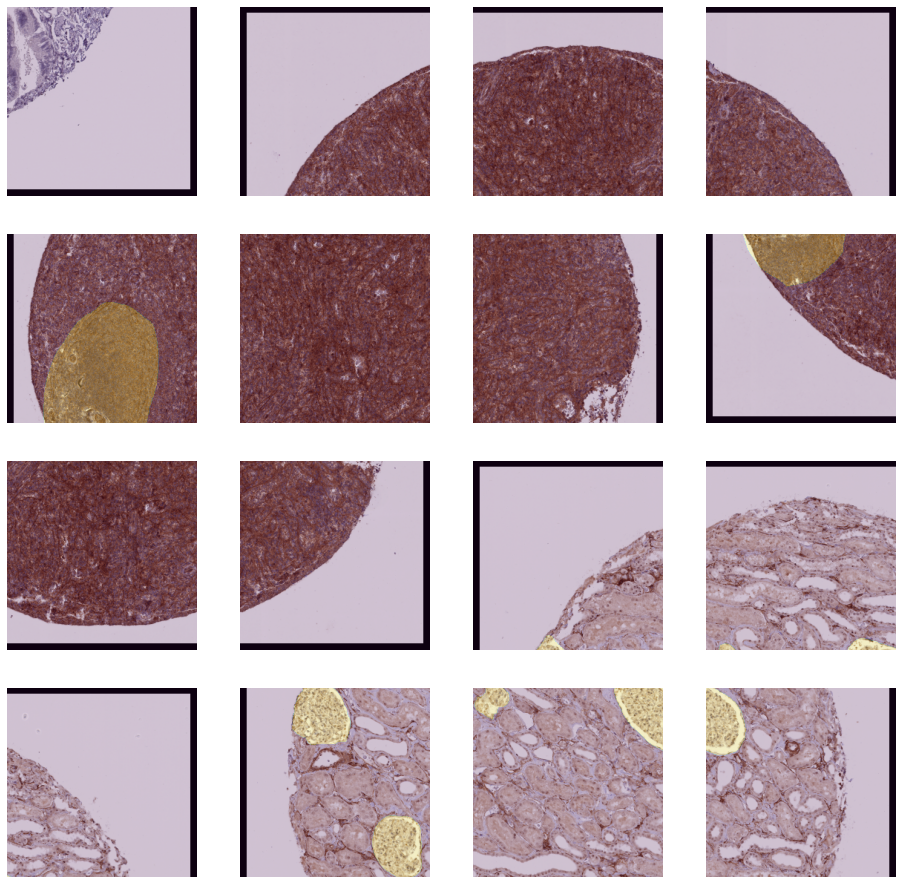

In [ ]:
columns, rows = 4,4
idx0 = 20
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()